## Assignment : 14

<pre>
1. You can work with preprocessed_data.csv for the assignment. You can get the data from - <a href='https://drive.google.com/drive/u/0/folders/1CJnItndeSSJu7aragQoXWZS9-0apN6pp'>Data folder </a>
2. Load the data in your notebook.
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a  href='https://stackoverflow.com/a/46844409'>this</a> and <a  href='https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/80807'>this</a> for using auc as a metric 
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum.
7. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in a separate pad and write your observations about them.
8. Make sure that you are using GPU to train the given models.
</pre>

In [1]:
#importing libraries 
import pandas as pd
import numpy as np 
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer,one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,CuDNNLSTM,SpatialDropout1D
from keras.models import Sequential
from keras import Model,Input
from time import time
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.regularizers import l2
import pickle
from keras.layers.convolutional import Conv2D,Conv1D
import keras.backend as k
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from keras.initializers import he_normal
from keras.callbacks import Callback, EarlyStopping


In [ ]:
#you can use gdown modules to import dataset for the assignment
#for importing any file from drive to Colab you can write the syntax as !gdown --id file_id
#you can run the below cell to import the required preprocessed data.csv file and glove vector

## <font color='red'> Model-1 </font>
Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

# <font color='red'> Model-1 </font>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Reading the dataset
project_data = pd.read_csv('/content/drive/MyDrive/preprocessed_data.csv')
project_data.head(3)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


In [4]:
# defining the class label varibale 
class_label = project_data['project_is_approved']


In [5]:
# droping class label data
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
X = project_data
project_data.shape

(109248, 8)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

print('Train Data Set', X_train.shape, y_train.shape)
print('Cross Validate Data Set', X_cv.shape, y_cv.shape)
print('Test Data Set', X_test.shape, y_test.shape)

Train Data Set (69918, 8) (69918,)
Cross Validate Data Set (17480, 8) (17480,)
Test Data Set (21850, 8) (21850,)


In [7]:
project_data.replace(to_replace=np.NaN, value= str('nan'),inplace=True)


In [8]:
col = project_data.columns
col

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price'],
      dtype='object')

In [9]:
col = ['teacher_prefix', 'school_state', 'project_grade_category',
       'clean_categories', 'clean_subcategories','essay',
       'price']
project_data = project_data[col]

In [4]:
# reading the pre trained word vectors file
dumb_file = open('/content/drive/MyDrive/Colab Notebooks/glove_vectors', 'rb')      
dumb = pickle.load(dumb_file)

In [5]:
dumb['mallinson'].shape

(300,)

In [12]:

def word_ranking(dataframe):
    # performing train test split
    train, test, y_train, y_test = train_test_split(dataframe, class_label, stratify=class_label, train_size=0.7)
    train, cv, y_train, y_cv = train_test_split(train, y_train, stratify=y_train, train_size=0.8)

    # column names to consider
    col_names = dataframe.columns[:6]

    # list to store features for each column
    features = []

    # iterate over each column
    for col in col_names:
        # create CountVectorizer and fit on train data
        vectorizer = CountVectorizer(lowercase=False)
        bow_train = vectorizer.fit_transform(train[col])

        # get word frequencies and sort by frequency
        word_freqs = bow_train.sum(axis=0).A1
        word_indices = word_freqs.argsort()[::-1]
        words = vectorizer.get_feature_names()

        # assign ranks to words based on frequency
        word_rank = {word: rank+1 for rank, idx in enumerate(word_indices) for word in [words[idx]]}
        features.append(word_rank)

        # replace words with their ranks in train, test, and cv data
        for df in [train, test, cv]:
            ranks = []
            for sent in df[col].values:
                txt_row = [word_rank.get(word, 0) for word in sent.split()]
                ranks.append(txt_row)
            df[col] = ranks

    return train, test, cv, y_train, y_test, y_cv, features

In [13]:
train,test,cv,y_train,y_test,y_cv,feature_names = word_ranking(project_data)


In [14]:
print("Shape of the Train dataset: ", train.shape[0])
print("Shape of the Test dataset: ", test.shape[0])
print("Shape of the cv dataset:", cv.shape[0])

Shape of the Train dataset:  61178
Shape of the Test dataset:  32775
Shape of the cv dataset: 15295


In [15]:
#converting class labels to categorical variables
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_cv = to_categorical(y_cv)


In [16]:
from sklearn.utils import compute_class_weight
class_wght = compute_class_weight("balanced", classes= np.unique(class_label),y=class_label)
class_wght



array([3.30214001, 0.58921753])

In [17]:
feature_names[4]


{'literacy': 1,
 'mathematics': 2,
 'literature_writing': 3,
 'specialneeds': 4,
 'appliedsciences': 5,
 'health_wellness': 6,
 'visualarts': 7,
 'environmentalscience': 8,
 'gym_fitness': 9,
 'esl': 10,
 'health_lifescience': 11,
 'earlydevelopment': 12,
 'music': 13,
 'history_geography': 14,
 'college_careerprep': 15,
 'other': 16,
 'teamsports': 17,
 'charactereducation': 18,
 'performingarts': 19,
 'socialsciences': 20,
 'care_hunger': 21,
 'warmth': 22,
 'nutritioneducation': 23,
 'foreignlanguages': 24,
 'extracurricular': 25,
 'civics_government': 26,
 'parentinvolvement': 27,
 'financialliteracy': 28,
 'communityservice': 29,
 'economics': 30}

In [6]:
#Creating a matrix with rows as words and columns with 50 dim vectors for each word
def embedding_mat(word_index,embedding_dim = 300):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = dumb.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

#Tokenizing the Text part


In [19]:
max_review_length = 250

X_train = pad_sequences(train['essay'], maxlen=max_review_length, padding='pre', truncating='pre')
X_test = pad_sequences(test['essay'], maxlen=max_review_length, padding='pre', truncating='pre')
X_cv = pad_sequences(cv['essay'], maxlen=max_review_length, padding='pre', truncating='pre')

print(X_train.shape)
print(X_train[256])


(61178, 250)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    3    1   21   86  130  136  978
 2211 3700   13  415   63  296   80   13   27  162  336 1605 2570 1918
  827  166   29   24    1  447    7   97   62  122   70  356    0   70
    5   24    2  373    1  177  441  228 7477 2924    1  749  270  568
  203    0  361   48   26  149  172  125  760   37   16  101 243

#Tokenizing the school state


In [20]:

max_review_length = 1
# here we are using prepadding 
X_train_school_state = pad_sequences(train['school_state'], maxlen=max_review_length, padding='pre', truncating='pre')
X_test_school_state = pad_sequences(test['school_state'], maxlen=max_review_length, padding='pre', truncating='pre')
X_cv_school_state = pad_sequences(cv['school_state'], maxlen=max_review_length, padding='pre', truncating='pre')

print(X_test_school_state.shape)
print(X_test_school_state[0])

(32775, 1)
[2]


#Tokenizing the project_grade_category


In [21]:
max_review_length = 1
X_train_project_grade = pad_sequences(train['project_grade_category'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_project_grade = pad_sequences(test['project_grade_category'], maxlen=max_review_length)
X_cv_project_grade = pad_sequences(cv['project_grade_category'], maxlen=max_review_length)
print(X_train_project_grade.shape)
print(X_train_project_grade[0])

(61178, 1)
[1]


#Tokenizing the clean_categories


In [22]:
max_review_length = 1
X_train_clean_categories = pad_sequences(train['clean_categories'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_clean_categories = pad_sequences(test['clean_categories'], maxlen=max_review_length)
X_cv_clean_categories = pad_sequences(cv['clean_categories'], maxlen=max_review_length)
print(X_train_clean_categories.shape)
print(X_train_clean_categories[0])

(61178, 1)
[2]


#Tokenizing the clean_subcategories


In [23]:
max_review_length = 1
X_train_clean_subcategories = pad_sequences(train['clean_subcategories'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_clean_subcategories = pad_sequences(test['clean_subcategories'], maxlen=max_review_length)
X_cv_clean_subcategories = pad_sequences(cv['clean_subcategories'], maxlen=max_review_length)
print(X_train_clean_subcategories.shape)
print(X_train_clean_subcategories[0])

(61178, 1)
[2]


#Tokenizing the teacher prefix


In [24]:
max_review_length = 1
X_train_teacher_prefix = pad_sequences(train['teacher_prefix'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_teacher_prefix = pad_sequences(test['teacher_prefix'], maxlen=max_review_length)
X_cv_teacher_prefix = pad_sequences(cv['teacher_prefix'], maxlen=max_review_length)
print(X_train_teacher_prefix.shape)
print(X_test_teacher_prefix[0])

(61178, 1)
[1]


In [25]:
train.head()

,teacher_prefix,school_state,project_grade_category,clean_categories,clean_subcategories,essay,price
56757,[2],[22],[1],[2],[2],"[3, 1, 21, 117, 139, 50, 58, 0, 48, 188, 38, 2...",60.59
5580,[2],[6],[3],"[5, 4]","[16, 4]","[105, 75, 42, 59, 1, 29, 11805, 7, 2483, 731, ...",269.99
18657,[1],[5],[1],[4],[4],"[0, 48, 501, 937, 546, 0, 1, 8366, 129, 214, 1...",693.06
13892,[1],[3],[2],"[1, 4]","[3, 4]","[0, 332, 1240, 366, 2, 29, 443, 1044, 3761, 22...",56.92
94161,[1],[18],[2],[1],"[10, 1]","[3, 1, 21, 51, 134, 86, 393, 139, 11, 187, 86,...",335.49


#Deep Learning Models
Model 1

In [26]:
# defining the auc score for model 
def auc( y_true, y_pred ) :
    score = tf.numpy_function(lambda y_true, y_pred : roc_auc_score( y_true, y_pred ,average='weighted').astype('float32'),
                        [y_true, y_pred],
                        'float32',
                        name='sklearnAUC')
    return score


# defining the accuracy score for model 

def accuracy(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    accuracy = tf.keras.metrics.Accuracy()
    accuracy.update_state(y_true, y_pred)
    return accuracy.result().numpy()



# defining learning rate function with value of 0.0001
def step_decay(epoch):
    initial_lr = 0.0001
    lr_drop = 1e-6
    epochs_drop = 1
    lr = initial_lr * math.pow(lr_drop, math.floor((1 + epoch) / epochs_drop))
    return lr

In [28]:
#input 1
input1 = Input(shape=(250,))
x1 = Embedding(input_dim=44899,output_dim= 300,weights=[embedding_mat(feature_names[5])],trainable=False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#input 2
input2 = Input(shape=(1,))
x2 = Embedding(input_dim= 52,output_dim= 2)(input2)
x2 = Flatten()(x2)

#input 3
input3 = Input(shape=(1,))
x3 = Embedding(input_dim= 5,output_dim= 2)(input3)
x3 = Flatten()(x3)

#input 4
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=50,output_dim= 2)(input4)
x4 = Flatten()(x4)

#input 5
input5 = Input(shape=(1,))
x5 = Embedding(input_dim= 385,output_dim= 50)(input5)
x5 = Flatten()(x5)

#input 6
input6 = Input(shape=(1,))
x6 = Embedding(input_dim= 6,output_dim= 5)(input6)
x6 = Flatten()(x6)

#input 7
input7 = Input(shape=(1,))
x7 = Dense(16,activation='sigmoid',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
# now will merge all the input layer using concatenate function 
concated_layer = concatenate([x1,x2,x3,x4,x5,x6,x7])
#x = BatchNormalization()(concat)

x = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concated_layer)
x = Dropout(0.3)(x)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.3)(x)
output = Dense(2, activation = 'softmax')(x)
 
# created the model with all inputs 
model = Model([input1,input2,input3,input4,input5,input6,input7], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006),metrics=['accuracy' ,auc])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 250, 300)     13469700    ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 250, 300)    0           ['embedding_1[0][0]']            
 out1D)                                                                                           
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                           

In [29]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
#now fit and train the model 
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="weights_2.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Remove TensorBoard from the callbacks_list
model.fit([X_train, X_train_school_state, X_train_project_grade, X_train_clean_categories, X_train_clean_subcategories, 
           X_train_teacher_prefix, train['price']], y_train, epochs=50, verbose=1, batch_size=256,
          validation_data=([X_cv, X_cv_school_state, X_cv_project_grade, X_cv_clean_categories, X_cv_clean_subcategories,    
                            X_cv_teacher_prefix, cv['price']], y_cv), callbacks=callbacks_list)


Epoch 1/50


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


238/239 [============================>.] - ETA: 0s - loss: 0.5400 - accuracy: 0.8278 - auc: 0.5216
Epoch 00001: val_auc improved from -inf to 0.52008, saving model to weights_2.best.hdf5
239/239 [==============================] - 20s 57ms/step - loss: 0.5397 - accuracy: 0.8279 - auc: 0.5218 - val_loss: 0.5122 - val_accuracy: 0.8486 - val_auc: 0.5201
Epoch 2/50
239/239 [==============================] - ETA: 0s - loss: 0.4754 - accuracy: 0.8465 - auc: 0.5962
Epoch 00002: val_auc improved from 0.52008 to 0.67297, saving model to weights_2.best.hdf5
239/239 [==============================] - 13s 56ms/step - loss: 0.4754 - accuracy: 0.8465 - auc: 0.5962 - val_loss: 0.4409 - val_accuracy: 0.8486 - val_auc: 0.6730
Epoch 3/50
239/239 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8477 - auc: 0.6676
Epoch 00003: val_auc improved from 0.67297 to 0.72061, saving model to weights_2.best.hdf5
239/239 [==============================] - 13s 55ms/step - loss: 0.4455 - accurac

# **We have got the auc score 99.59 % and accuracy 98.70**

In [31]:
#input 1
input1 = Input(shape=(250,))
x1 = Embedding(input_dim=44899,output_dim= 300,weights=[embedding_mat(feature_names[5])],trainable=False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#input 2
input2 = Input(shape=(1,))
x2 = Embedding(input_dim= 52,output_dim= 2)(input2)
x2 = Flatten()(x2)

#input 3
input3 = Input(shape=(1,))
x3 = Embedding(input_dim= 5,output_dim= 2)(input3)
x3 = Flatten()(x3)

#input 4
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=50,output_dim= 2)(input4)
x4 = Flatten()(x4)

#input 5
input5 = Input(shape=(1,))
x5 = Embedding(input_dim= 385,output_dim= 50)(input5)
x5 = Flatten()(x5)

#input 6
input6 = Input(shape=(1,))
x6 = Embedding(input_dim= 6,output_dim= 5)(input6)
x6 = Flatten()(x6)

#input 7
input7 = Input(shape=(1,))
x7 = Dense(16,activation='sigmoid',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
# now will merge all the input layer using concatenate function 
concated_layer = concatenate([x1,x2,x3,x4,x5,x6,x7])
#x = BatchNormalization()(concat)

x = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concated_layer)
x = Dropout(0.3)(x)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.3)(x)
output = Dense(2, activation = 'softmax')(x)
 
# created the model with all inputs 
model = Model([input1,input2,input3,input4,input5,input6,input7], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006),metrics=['accuracy' ,auc])
model.load_weights("weights_2.best.hdf5")


In [32]:
print("Auc for test data: %0.3f"%roc_auc_score(y_test,model.predict([X_test,X_test_school_state,X_test_project_grade,X_test_clean_categories,X_test_clean_subcategories,
           X_test_teacher_prefix,test['price']])))
print("Auc for CV data: %0.3f"%roc_auc_score(y_cv,model.predict([X_cv,X_cv_school_state,X_cv_project_grade,X_cv_clean_categories,X_cv_clean_subcategories,
           X_cv_teacher_prefix,cv['price']])))
print("Auc for train data: %0.3f"%roc_auc_score(y_train,model.predict([X_train,X_train_school_state,X_train_project_grade,X_train_clean_categories,X_train_clean_subcategories,
           X_train_teacher_prefix,train['price']])))

1025/1025 [==============================] - 8s 7ms/step
Auc for test data: 0.752
478/478 [==============================] - 3s 6ms/step
Auc for CV data: 0.760
1912/1912 [==============================] - 12s 6ms/step
Auc for train data: 0.796


In [33]:
from tensorflow.keras.utils import plot_model


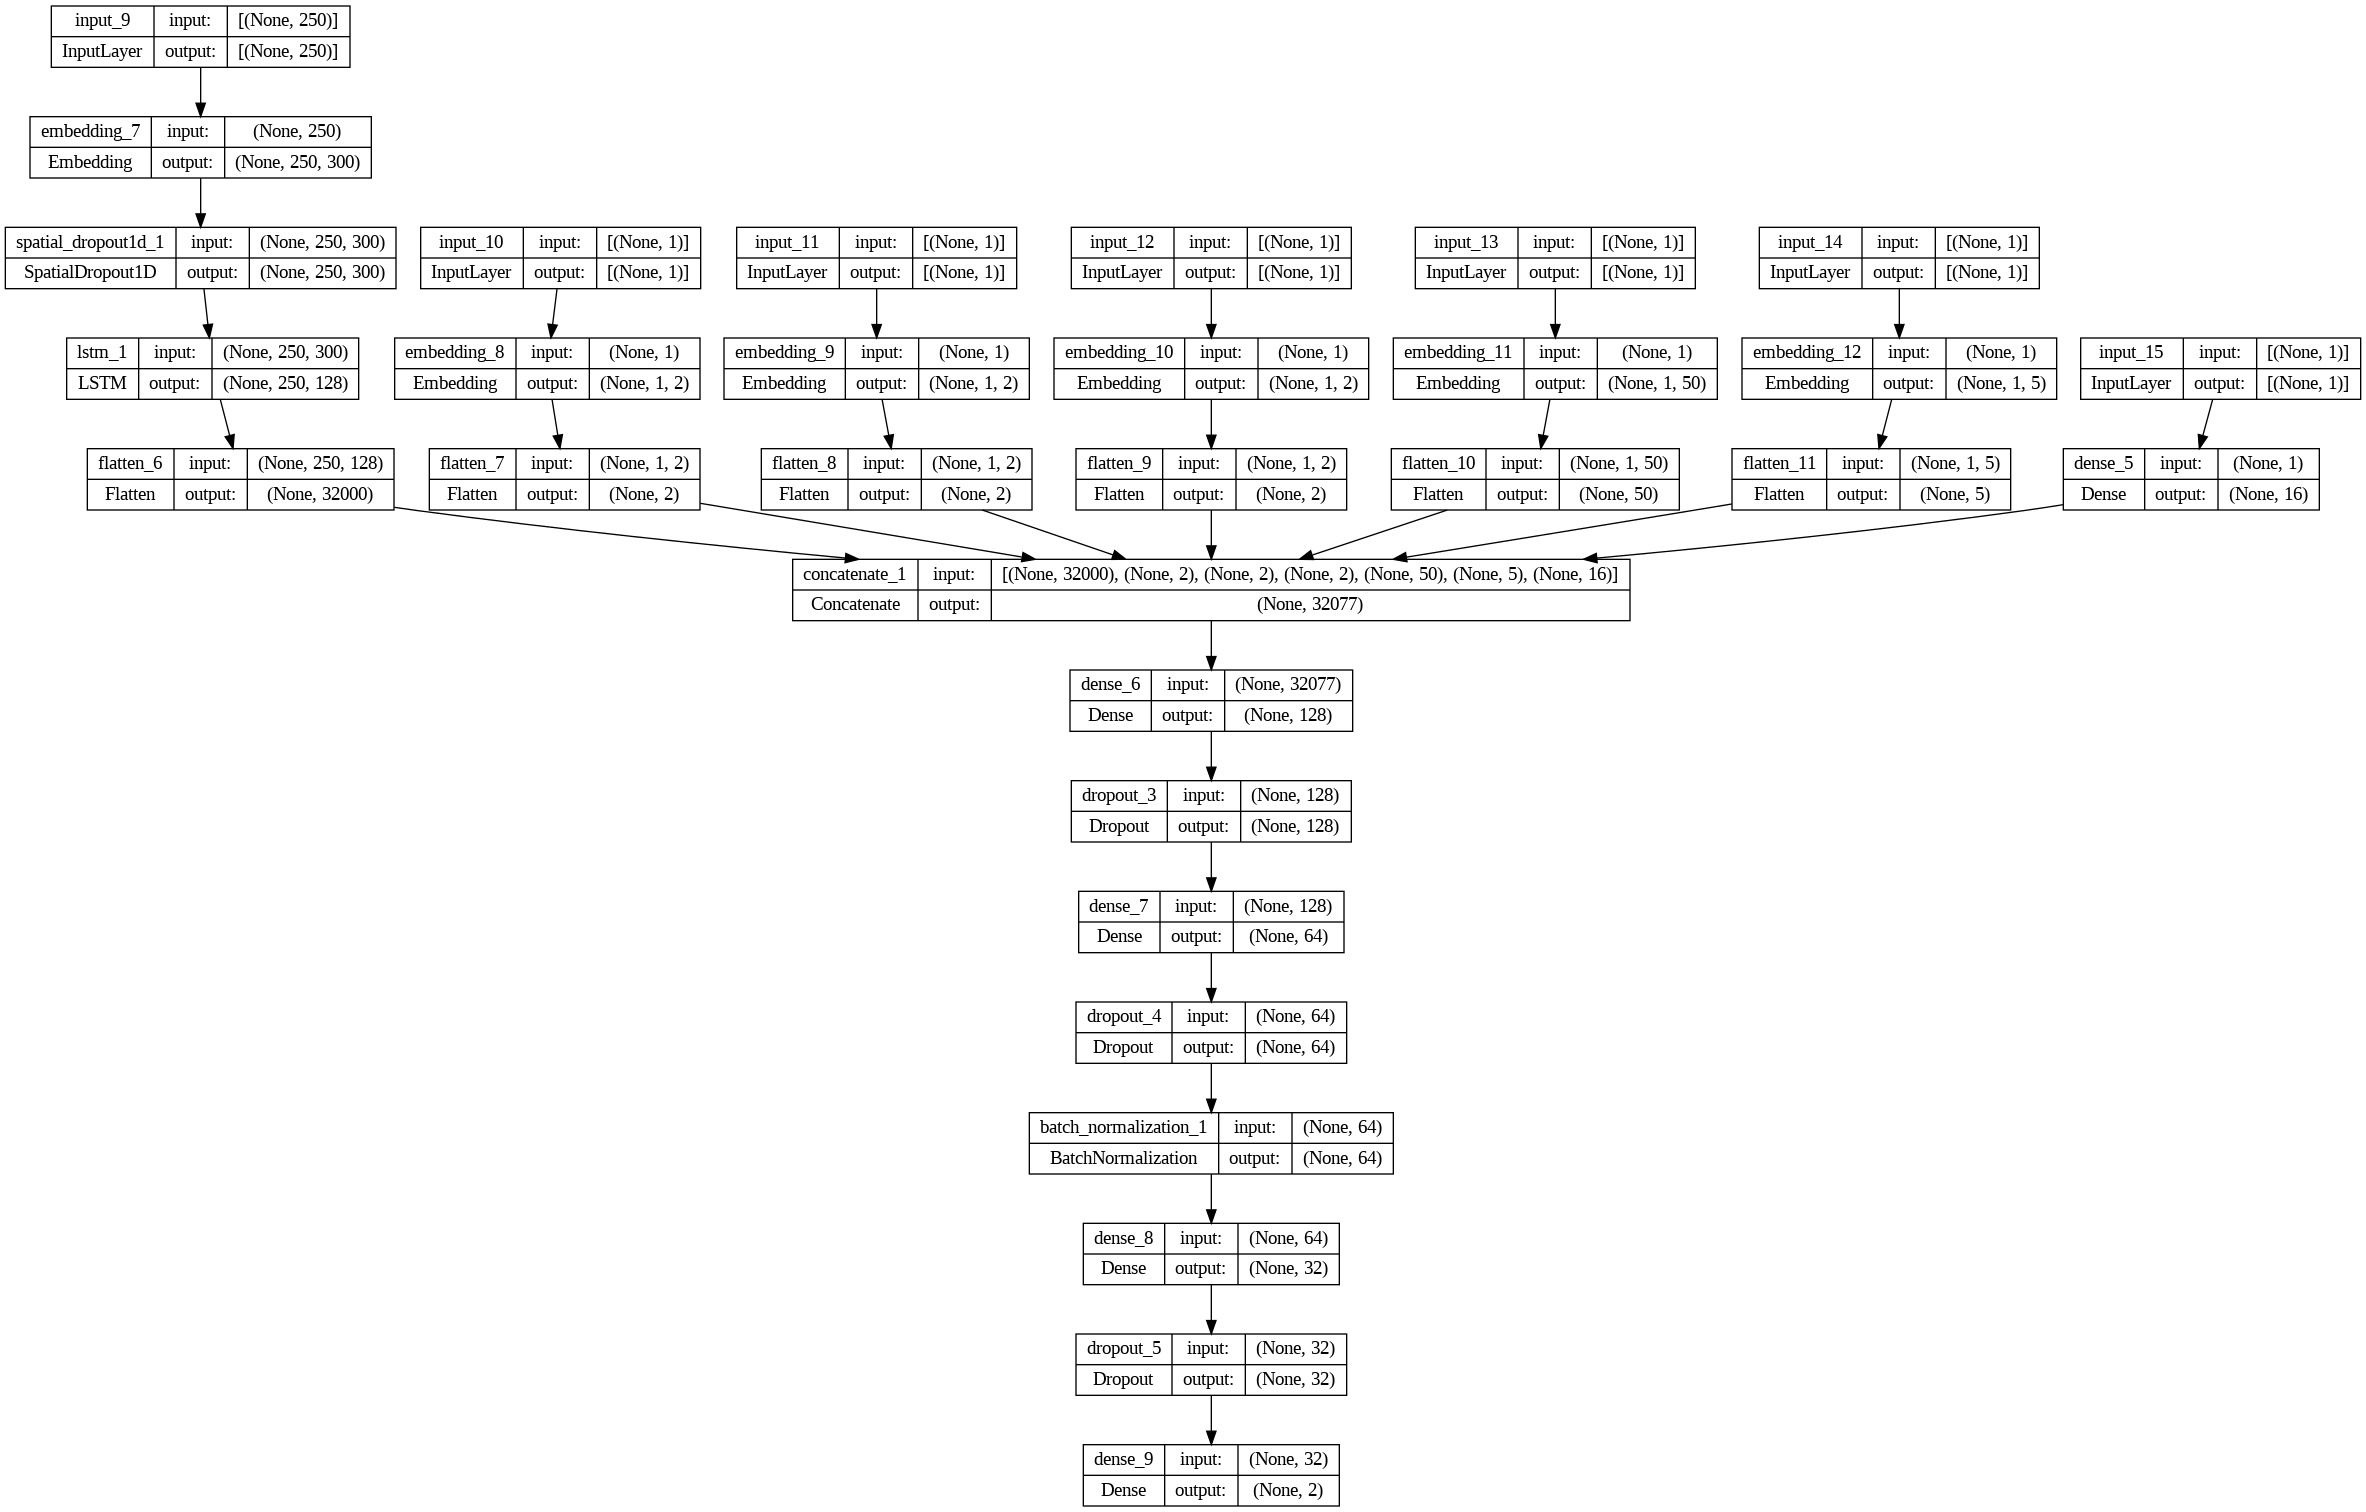

In [34]:
plot_model(model, to_file='model.png', show_shapes=True)


# <font color='red'> Model-2 </font>

#Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Fit TF-IDF vectorizer on the Train data <br>
2. Get the idf value for each word we have in the train data. Please go through <a  href='https://stackoverflow.com/questions/23792781/tf-idf-feature-weights-using-sklearn-feature-extraction-text-tfidfvectorizer'>this</a><br>

3. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very 
frequent words and very very rare words don't give much information.
Hint - A preferable IDF range is 2-11 for model 2. <br>
4.Remove the low idf value and high idf value words from the train and test data. You can go through each of the
sentence of train and test data and include only those features(words) which are present in the defined IDF range.
5. Perform tokenization on the modified text data same as you have done for previous model.
6. Create embedding matrix for model 2 and then use the rest of the features similar to previous model.
7. Define the model, compile and fit the model.
</pre>

In [7]:
class_label = project_data['project_is_approved']


In [8]:
#train test split
train,test,y_train,y_test = train_test_split(project_data, class_label , stratify = class_label, train_size = 0.7)


In [9]:
train,cv,y_train,y_cv = train_test_split(train,y_train,stratify = y_train,train_size = 0.8)


In [10]:
print("Shape of the Train dataset: ", train.shape[0])
print("Shape of the Test dataset: ", test.shape[0])
print("Shape of the CV Dataset:", cv.shape[0])

Shape of the Train dataset:  61178
Shape of the Test dataset:  32775
Shape of the CV Dataset: 15295


In [11]:
# refer : https://stackoverflow.com/questions/67018079/error-in-from-keras-utils-import-to-categorical

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_cv = to_categorical(y_cv)

In [12]:
# now we are creating rows and columns as 50 dimensional vector 

def embedding_mat(word_index,embedding_dim = 300):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector =dumb.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

Text(0, 0.5, 'IDF score')

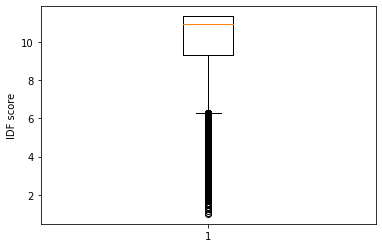

In [13]:

# Convert the data in the 'total_txt' column to a list of strings
#tfidf vectorization of text data

tfidf = TfidfVectorizer()
data_text = tfidf.fit_transform(train['essay'])
plt.boxplot(tfidf.idf_)
plt.ylabel("IDF score")

In [14]:
print("The 25 percentile of idf score is :", np.percentile(tfidf.idf_,[25]))
print("The 75 percentile of idf score is :",np.percentile(tfidf.idf_,[75]))

The 25 percentile of idf score is : [9.31350907]
The 75 percentile of idf score is : [11.32841209]


In [15]:
feature_idf = zip(tfidf.get_feature_names(),tfidf.idf_)

feature_name = []
for x,y in feature_idf:
    
    if y >=9.31350907 and 11.32841209 :
        feature_name.append(x)
    else:
        pass

In [16]:
def few_text(df, feature_name):
    processed_text = []
    feature_set = set(feature_name)
    for text in df:
        sent = " ".join([word for word in text.split() if word in feature_set])
        processed_text.append(sent)
    return processed_text

train['processed_essay'] = few_text(train['essay'], feature_name)
test['processed_essay'] = few_text(test['essay'], feature_name)
cv['processed_essay'] = few_text(cv['essay'], feature_name)


# now we are converting all the data to cs files 
train.to_csv("model-train.csv", index=False)
test.to_csv("model-test.csv", index=False)
cv.to_csv("model-cv.csv", index=False)


In [17]:
train['essay'] =  train['essay'] 
test['essay'] = test['essay'] 
cv['essay'] = cv['essay'] 

In [18]:
y_train = train['project_is_approved']
y_test = test['project_is_approved']
y_cv = cv['project_is_approved']

# converting the class labels to one hot encoding for keras model evaluation
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_cv = to_categorical(y_cv)

In [19]:
train.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,processed_essay
103461,pa,mrs,grades_3_5,100,1,history_civics,financialliteracy,when comes money many things life understandin...,132.20,tagene mcbean algeria sunday
76709,ok,mrs,grades_3_5,9,1,literacy_language math_science,literature_writing mathematics,students 3rd grade classroom live rural commun...,9.09,


In [20]:
def word_ranking(train, test, cv):
    col_names = train.columns
    features = []
    
    for col in col_names[:6]:
        print(col)
        bag_of_words = CountVectorizer(lowercase=False)
        bow_words = bag_of_words.fit_transform(train[col])
        print(bow_words.shape)
        
        # Rank the words by frequency of occurrence
        word_freqs = dict(zip(bag_of_words.get_feature_names(), bow_words.sum(axis=0).A1))
        sorted_words = sorted(word_freqs, key=word_freqs.get, reverse=True)
        word_rank = dict(zip(sorted_words, range(1, len(sorted_words) + 1)))
        features.append(word_rank)
        
        # Replace words with their rank
        train[col] = [[word_rank[word] for word in sent.split() if word in word_rank] for sent in train[col].values]
        test[col] = [[word_rank[word] for word in sent.split() if word in word_rank] for sent in test[col].values]
        cv[col] = [[word_rank[word] for word in sent.split() if word in word_rank] for sent in cv[col].values]
    
    return train, test, cv, features
            

In [21]:
col = ['teacher_prefix', 'school_state', 'project_grade_category',
       'clean_categories', 'clean_subcategories','essay',
       'price']
train = train[col]
test = test[col]
test = test[col]

# **replacing nan value**

In [22]:
train.replace(to_replace=np.NaN, value= str('nan'),inplace=True)
test.replace(to_replace=np.NaN, value= str('nan'),inplace=True)
cv.replace(to_replace=np.NaN, value= str('nan'),inplace=True)

In [23]:
train,test,cv,feature_names =  word_ranking(train,test,cv)


teacher_prefix
(61178, 5)
school_state
(61178, 51)
project_grade_category
(61178, 4)
clean_categories
(61178, 9)
clean_subcategories
(61178, 30)
essay
(61178, 45000)


#Tokenizing the Test part


In [46]:
max_review_length = 250
X_train = pad_sequences(train['essay'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test = pad_sequences(test['essay'], maxlen=max_review_length)
X_cv = pad_sequences(cv['essay'], maxlen=max_review_length)
print(X_test.shape)
print(X_train[256])

(32775, 250)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    3    1   21   11  103  139   34 1282  280   67
  126    5   24    5  322 1540  104   60  412  194 3214  202  579   59
  212    1 1200 2701    3    1 2744  143   84   29  314  497 1532  104
   60   57 3026   77 1200   24    2 1198  158 1523  123    4   73  125
 1274   25 2596 1543  205 1475 1383    1   24    2 2068  412 8199   59
   57  113  212  497 1532  104   60    1   84  437  227   52 4565  460
 2615   30 3565   42    1   65 1127  117  457   15  152  682  43

#Tokenizing the school state


In [37]:
max_review_length = 1
X_train_school_state = pad_sequences(train['school_state'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_school_state = pad_sequences(test['school_state'], maxlen=max_review_length)
X_cv_school_state = pad_sequences(cv['school_state'], maxlen=max_review_length)
print(X_test_school_state.shape)
print(X_test_school_state[0])

(32775, 1)
[1]


#Tokenizing the project_grade_category


In [45]:
max_review_length = 1
X_train_project_grade = pad_sequences(train['project_grade_category'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_project_grade = pad_sequences(test['project_grade_category'], maxlen=max_review_length)
X_cv_project_grade = pad_sequences(cv['project_grade_category'], maxlen=max_review_length)
print(X_test_project_grade.shape)
print(X_train_project_grade[0])

(32775, 1)
[2]


#Tokenizing the project categories


In [44]:
max_review_length = 1
X_train_clean_categories = pad_sequences(train['clean_categories'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_clean_categories = pad_sequences(test['clean_categories'], maxlen=max_review_length)
X_cv_clean_categories = pad_sequences(cv['clean_categories'], maxlen=max_review_length)
print(X_test_clean_categories.shape)
print(X_train_clean_categories[0])

(32775, 1)
[7]


#Tokenizing the project subcategories


In [43]:
max_review_length = 1
X_train_clean_subcategories = pad_sequences(train['clean_subcategories'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_clean_subcategories = pad_sequences(test['clean_subcategories'], maxlen=max_review_length)
X_cv_clean_subcategories = pad_sequences(cv['clean_subcategories'], maxlen=max_review_length)
print(X_test_clean_subcategories.shape)
print(X_train_clean_subcategories[0])

(32775, 1)
[28]


#Tokenizing the teacher prefix


In [42]:
max_review_length = 1
X_train_teacher_prefix = pad_sequences(train['teacher_prefix'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test_teacher_prefix = pad_sequences(test['teacher_prefix'], maxlen=max_review_length)
X_cv_teacher_prefix = pad_sequences(cv['teacher_prefix'], maxlen=max_review_length)
print(X_test_teacher_prefix.shape)
print(X_test_teacher_prefix[0])


(32775, 1)
[1]


In [30]:
train.head()

,teacher_prefix,school_state,project_grade_category,clean_categories,clean_subcategories,essay,price
103461,[1],[10],[2],[7],[28],"[210, 511, 517, 11, 110, 67, 298, 3129, 1289, ...",132.20
76709,[1],[17],[2],"[1, 2]","[3, 2]","[1, 657, 38, 5, 188, 359, 73, 24, 73, 5449, 91...",9.09
15554,[1],[38],[3],[2],[2],"[3, 1, 147, 4335, 693, 1128, 211, 4, 879, 234,...",202.87
7724,[1],[1],[1],[1],[1],"[217, 1, 420, 964, 18, 31, 1792, 1541, 27, 197...",379.93
41174,[2],[1],[2],[1],[3],"[3, 570, 38, 1, 88, 30, 2, 29, 4, 395, 235, 23...",23.33


#Deep Learning Models
Model 1

In [31]:
# defining the auc score for model 
def auc( y_true, y_pred ) :
    score = tf.numpy_function(lambda y_true, y_pred : roc_auc_score( y_true, y_pred ,average='weighted').astype('float32'),
                        [y_true, y_pred],
                        'float32',
                        name='sklearnAUC')
    return score


# defining the accuracy score for model 

def accuracy(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    accuracy = tf.keras.metrics.Accuracy()
    accuracy.update_state(y_true, y_pred)
    return accuracy.result().numpy()



# defining learning rate function with value of 0.0001
def step_decay(epoch):
    initial_lr = 0.0001
    lr_drop = 1e-6
    epochs_drop = 1
    lr = initial_lr * math.pow(lr_drop, math.floor((1 + epoch) / epochs_drop))
    return lr



In [33]:
#input 1
input1 = Input(shape=(250,))
x1 = Embedding(input_dim=45001,output_dim= 300,weights=[embedding_mat(feature_names[5])],trainable=False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#input 2
input2 = Input(shape=(1,))
x2 = Embedding(input_dim= 55,output_dim= 2)(input2)
x2 = SpatialDropout1D(0.3)(x2)
x2 = Flatten()(x2)

#input 3
input3 = Input(shape=(1,))
x3 = Embedding(input_dim= 5,output_dim= 2)(input3)
x3 = SpatialDropout1D(0.3)(x3)
x3 = Flatten()(x3)

#input 4
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=50,output_dim= 2)(input4)
x4 = SpatialDropout1D(0.3)(x4)
x4 = Flatten()(x4)

#input 5
input5 = Input(shape=(1,))
x5 = Embedding(input_dim= 385,output_dim= 50)(input5)
x5 = SpatialDropout1D(0.3)(x5)
x5 = Flatten()(x5)

#input 6
input6 = Input(shape=(1,))
x6 = Embedding(input_dim= 6,output_dim= 5)(input6)
x6 = SpatialDropout1D(0.3)(x6)
x6 = Flatten()(x6)

#input 7
input7 = Input(shape=(1,))
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
x7 = Flatten()(x7)
# now will merge the all the input 
concatated_layer = concatenate([x1,x2,x3,x4,x5,x6,x7])

x = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concatated_layer)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=['accuracy',auc])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 250, 300)     13500300    ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

In [34]:
#model fitting
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="weights_2.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Remove TensorBoard from the callbacks_list
model.fit([X_train, X_train_school_state, X_train_project_grade, X_train_clean_categories, X_train_clean_subcategories, 
           X_train_teacher_prefix, train['price']], y_train, epochs=50, verbose=1, batch_size=256,
          validation_data=([X_cv, X_cv_school_state, X_cv_project_grade, X_cv_clean_categories, X_cv_clean_subcategories,    
                            X_cv_teacher_prefix, cv['price']], y_cv), callbacks=callbacks_list)

Epoch 1/50


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


239/239 [==============================] - ETA: 0s - loss: 0.5564 - accuracy: 0.8325 - auc: 0.5235
Epoch 00001: val_auc improved from -inf to 0.63329, saving model to weights_2.best.hdf5
239/239 [==============================] - 22s 61ms/step - loss: 0.5564 - accuracy: 0.8325 - auc: 0.5235 - val_loss: 0.4551 - val_accuracy: 0.8486 - val_auc: 0.6333
Epoch 2/50
239/239 [==============================] - ETA: 0s - loss: 0.4782 - accuracy: 0.8464 - auc: 0.5530
Epoch 00002: val_auc did not improve from 0.63329
239/239 [==============================] - 12s 51ms/step - loss: 0.4782 - accuracy: 0.8464 - auc: 0.5530 - val_loss: 0.4667 - val_accuracy: 0.8486 - val_auc: 0.5881
Epoch 3/50
239/239 [==============================] - ETA: 0s - loss: 0.4444 - accuracy: 0.8483 - auc: 0.6243
Epoch 00003: val_auc improved from 0.63329 to 0.68819, saving model to weights_2.best.hdf5
239/239 [==============================] - 13s 53ms/step - loss: 0.4444 - accuracy: 0.8483 - auc: 0.6243 - val_loss: 0.447

# **We have got the auc score 87.15% and accuracy 87.60%**

In [47]:
#input 1
input1 = Input(shape=(250,))
x1 = Embedding(input_dim=45001,output_dim= 300,weights=[embedding_mat(feature_names[5])],trainable=False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#input 2
input2 = Input(shape=(1,))
x2 = Embedding(input_dim= 55,output_dim= 2)(input2)
x2 = SpatialDropout1D(0.3)(x2)
x2 = Flatten()(x2)

#input 3
input3 = Input(shape=(1,))
x3 = Embedding(input_dim= 5,output_dim= 2)(input3)
x3 = SpatialDropout1D(0.3)(x3)
x3 = Flatten()(x3)

#input 4
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=50,output_dim= 2)(input4)
x4 = SpatialDropout1D(0.3)(x4)
x4 = Flatten()(x4)

#input 5
input5 = Input(shape=(1,))
x5 = Embedding(input_dim= 385,output_dim= 50)(input5)
x5 = SpatialDropout1D(0.3)(x5)
x5 = Flatten()(x5)

#input 6
input6 = Input(shape=(1,))
x6 = Embedding(input_dim= 6,output_dim= 5)(input6)
x6 = SpatialDropout1D(0.3)(x6)
x6 = Flatten()(x6)

#input 7
input7 = Input(shape=(1,))
x7 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
x7 = Flatten()(x7)
# now will merge the all the input 
concatated_layer = concatenate([x1,x2,x3,x4,x5,x6,x7])

x = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concatated_layer)
x = Dropout(0.5)(x)
x = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
model.load_weights("weights_2.best.hdf5")

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=['accuracy',auc])

In [50]:
print("Auc for test data: %0.3f"%roc_auc_score(y_test,model.predict([X_test,X_test_school_state,X_test_project_grade,X_test_clean_categories,X_test_clean_subcategories,
          X_test_teacher_prefix,test['price']])))
print("Auc for CV data: %0.3f"%roc_auc_score(y_cv,model.predict([X_cv,X_cv_school_state,X_cv_project_grade,X_cv_clean_categories,X_cv_clean_subcategories,
           X_cv_teacher_prefix,cv['price']])))
print("Auc for train data: %0.3f"%roc_auc_score(y_train,model.predict([X_train,X_train_school_state,X_train_project_grade,X_train_clean_categories,X_train_clean_subcategories,
           X_train_teacher_prefix,train['price']])))

1025/1025 [==============================] - 9s 9ms/step
Auc for test data: 0.763
478/478 [==============================] - 3s 6ms/step
Auc for CV data: 0.770
1912/1912 [==============================] - 13s 7ms/step
Auc for train data: 0.823


In [51]:
from tensorflow.keras.utils import plot_model


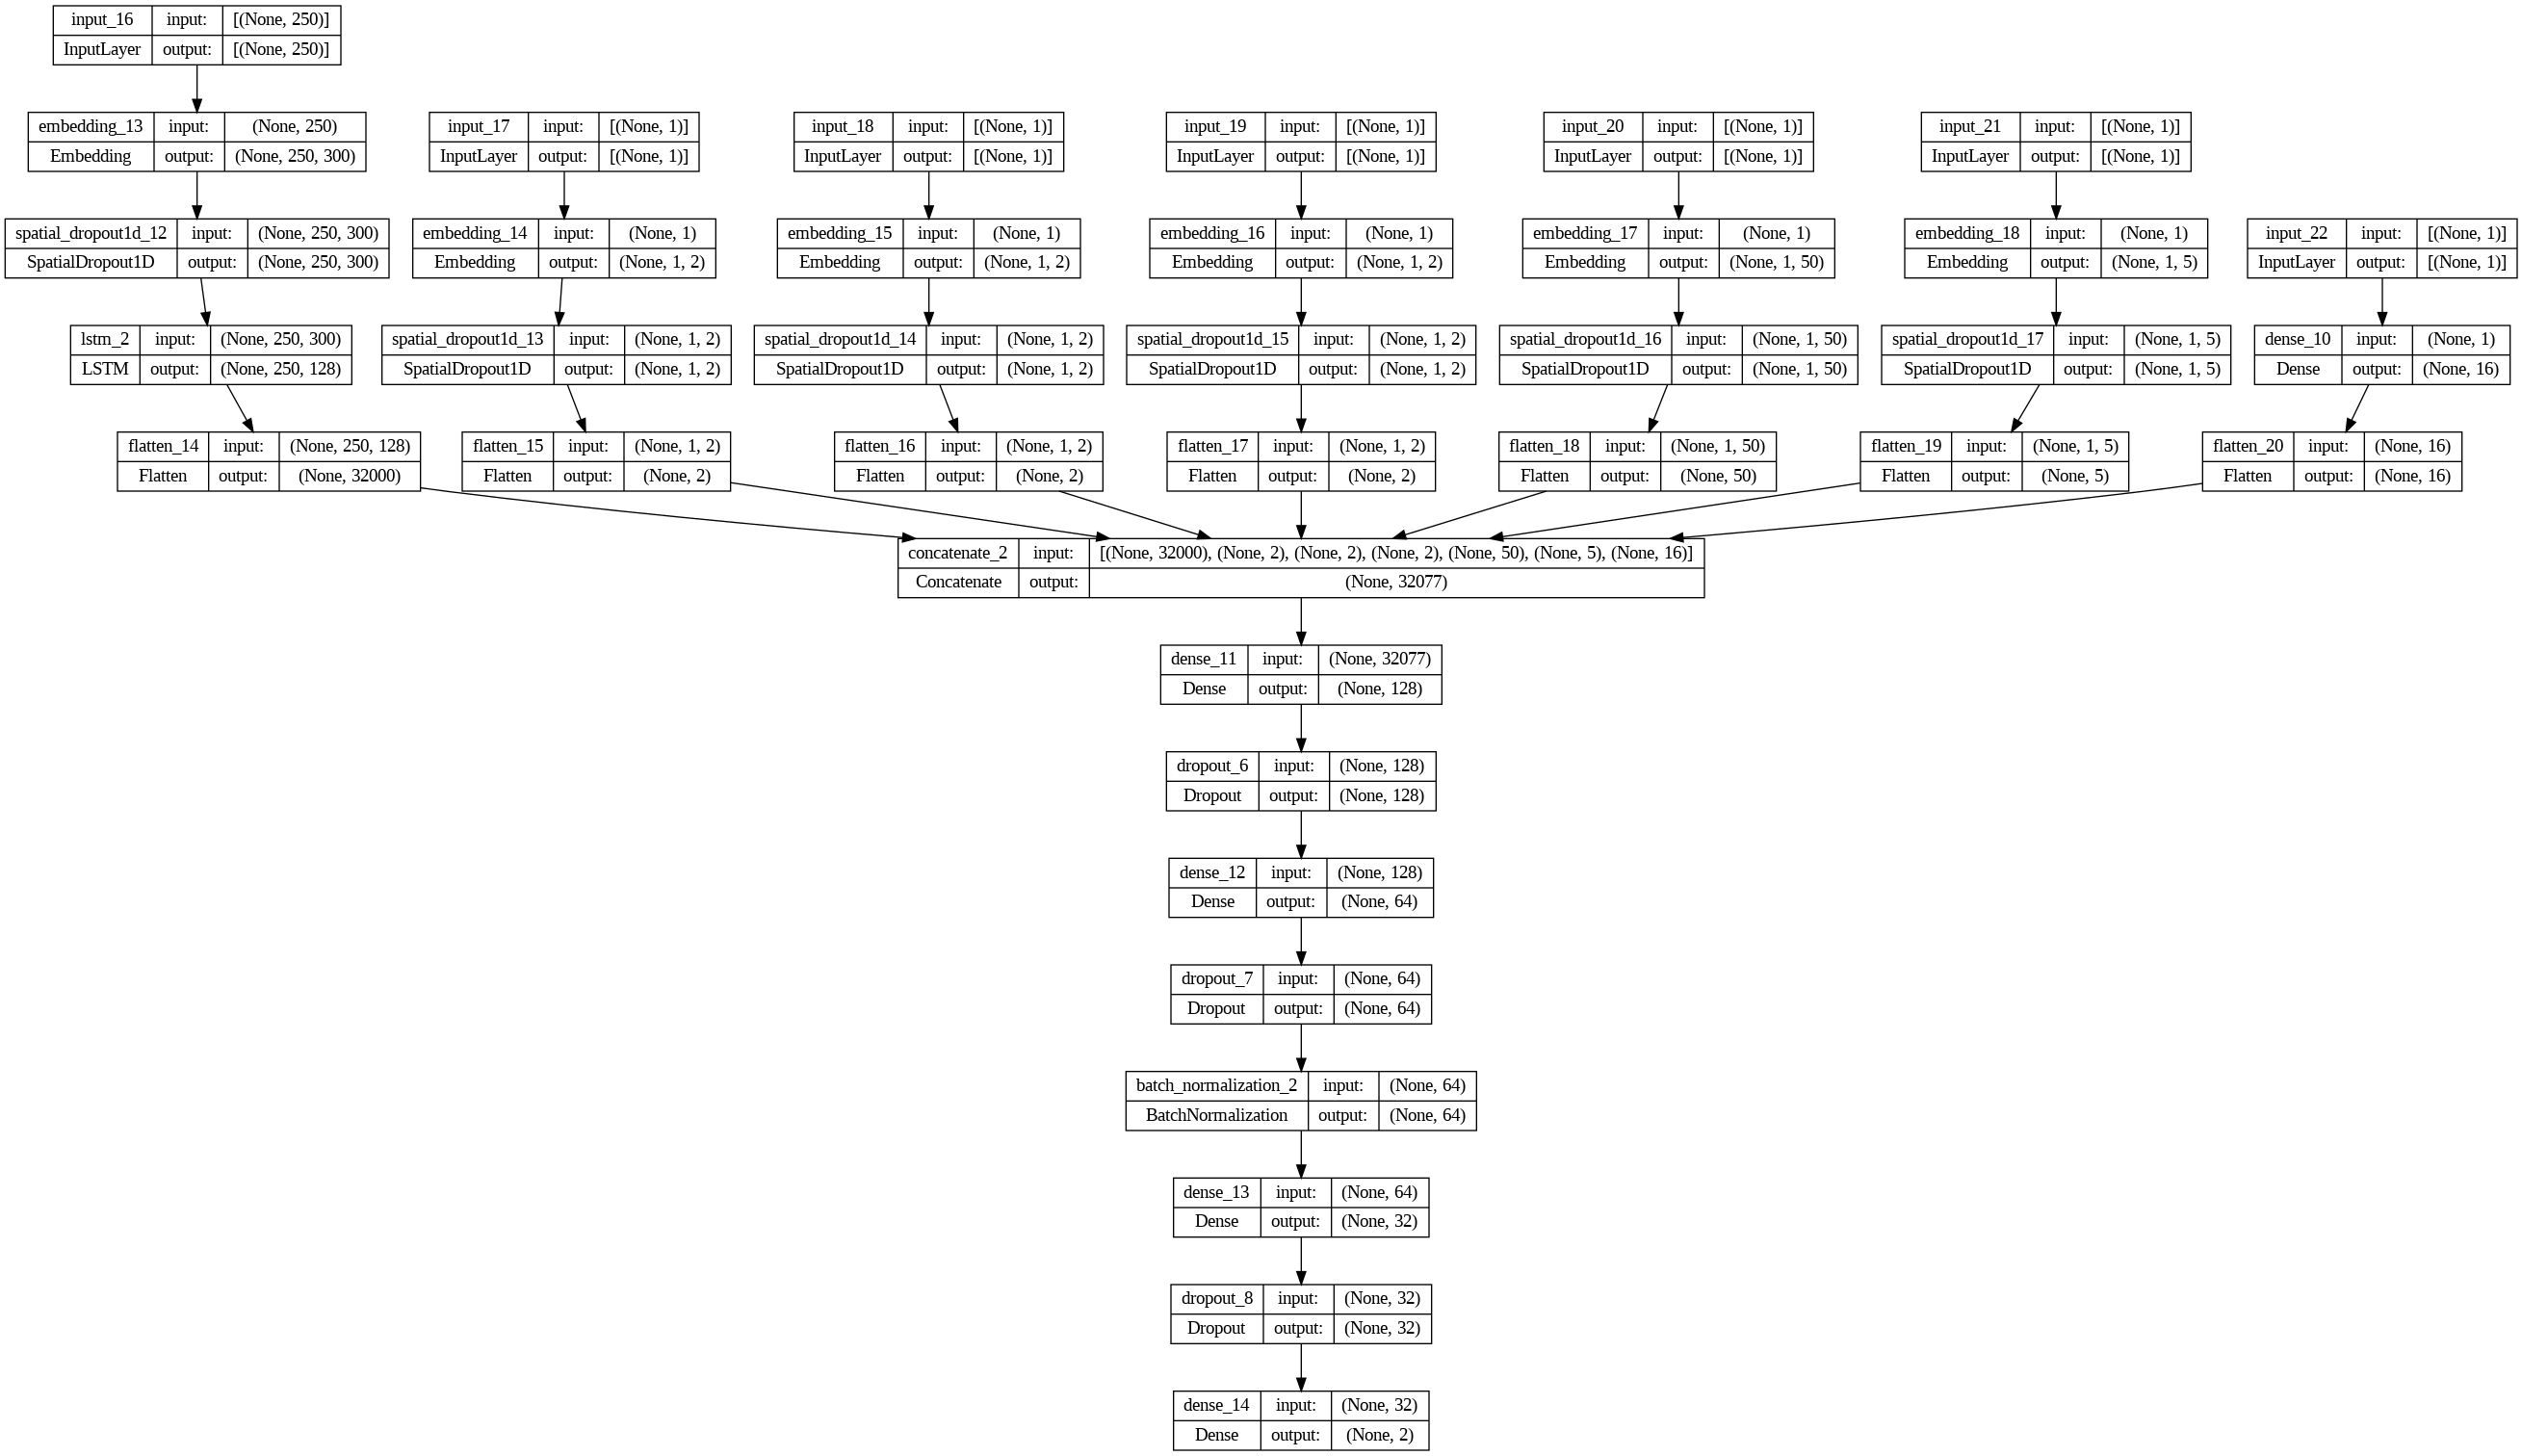

In [52]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)


# <font color='red'> Model-3 </font>

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png

In [ ]:
#in this model you can use the text vectorized data from model1 
#for other than text data consider the following steps
# you have to perform one hot encoding of categorical features. You can use onehotencoder() or countvectorizer() for the same.
# Stack up standardised numerical features and all the one hot encoded categorical features
#the input to conv1d layer is 3d, you can convert your 2d data to 3d using np.newaxis
# Note - deep learning models won't work with sparse features, you have to convert them to dense features before fitting in the model.

In [ ]:
#Reading the dataset
project_data = pd.read_csv('/content/drive/MyDrive/preprocessed_data.csv')
project_data.head(3)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


In [ ]:
class_label = project_data['project_is_approved']


In [ ]:
project_data.replace(to_replace=np.NaN, value= str('nan'),inplace=True)


In [ ]:
col = ['teacher_prefix', 'school_state', 'project_grade_category',
       'clean_categories', 'clean_subcategories','essay',
       'price']
project_data = project_data[col]

In [ ]:
 #ref : https://www.geeksforgeeks.org/frequent-word-array-strings/
def word_ranking(df):
    col_names = df.columns
    features = []
    #performing train test split
    train,test,y_train,y_test = train_test_split(df, class_label , stratify = class_label, train_size = 0.7)

    train,cv,y_train,y_cv = train_test_split(train,y_train,stratify = y_train,train_size = 0.8)
    for coln in col_names[5:6]:
        print(coln)
        bag_of_words = CountVectorizer(lowercase= False)
        bow_words = bag_of_words.fit_transform(train[coln])
        print(bow_words.shape)
        
        #Lets now store the document term matrix in a dictionary.
        freqs = bow_words.sum(axis=0).A1
        index = freqs.argsort()
        words = bag_of_words.get_feature_names()
        
        

        # Assigning Rank to each word based on its freq of occurance. Word with highest freq is assigned rank 1 
        word_rank = dict()
        rank = 1
        for i in index[::-1]:
            k = words[i]
            word_rank[k] = rank
            rank+=1
        features.append(word_rank)

        #Every word in each review is replaced by its rank
        rank = [] # list of all the review with words replaced with rank
        for sent in train[coln].values:
            txt_row = []
            for word in sent.split():
                if word in word_rank.keys():
                    txt_row.append(word_rank[word])
                else:
                    pass
            rank.append(txt_row)
        
        train[coln] = rank
        
        rank = [] # list of all the review with words replaced with rank
        for sent in test[coln].values:
            txt_row = []
            for word in sent.split():
                if word in word_rank.keys():
                    txt_row.append(word_rank[word])
                else:
                    pass
            rank.append(txt_row)
        
        test[coln] = rank
        
        rank = [] # list of all the review with words replaced with rank
        for sent in cv[coln].values:
            txt_row = []
            for word in sent.split():
                if word in word_rank.keys():
                    txt_row.append(word_rank[word])
                else:
                    pass
            rank.append(txt_row)
        
        cv[coln] = rank
    return train,test,cv,y_train,y_test,y_cv,features
            


In [ ]:
train,test,cv,y_train,y_test,y_cv,feature_names = word_ranking(project_data)


essay
(61178, 44986)


In [ ]:
print("Shape of the Train dataset: ", train.shape[0])
print("Shape of the Test dataset: ", test.shape[0])
print("Shape of the CV dataset: ", cv.shape[0])

Shape of the Train dataset:  61178
Shape of the Test dataset:  32775
Shape of the CV dataset:  15295


In [ ]:
y_train.shape


(61178,)

In [ ]:
#converting class labels to categorical variables
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_cv = to_categorical(y_cv)


#Tokenizing the Text part


In [ ]:
max_review_length = 250
X_train = pad_sequences(train['essay'], maxlen=max_review_length)  #padding zeros at the begining of each review to make max len as 200
X_test = pad_sequences(test['essay'], maxlen=max_review_length)
X_cv = pad_sequences(cv['essay'], maxlen=max_review_length)
print(X_train.shape)
print(X_train[256])

(61178, 250)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0    14  1433   116   294   142   197    13
   186     9   477   436     2    90   135   411     3   104    58     1
    18   116   205     1   103    59  6051    11   703    15   131   277
   116   616   116    43    88   206  

#Tokenizing the school state


In [ ]:
token_school_state = CountVectorizer()

# integer encode the documents
school_state_train = token_school_state.fit_transform(train['school_state'])
school_state_test = token_school_state.transform(test['school_state'])
school_state_cv = token_school_state.transform(cv['school_state'])

print(school_state_train.shape)

(61178, 51)


#Tokenizing the project_grade_category


In [ ]:
token_project_grade_category = CountVectorizer()

# integer encode the documents
project_grade_train = token_project_grade_category.fit_transform(train['project_grade_category'])
project_grade_test = token_project_grade_category.transform(test['project_grade_category'])
project_grade_cv = token_project_grade_category.transform(cv['project_grade_category'])

print(project_grade_train.shape)

(61178, 4)


#Tokenizing the project categories


In [ ]:
token_clean_categories = CountVectorizer()

# integer encode the documents
train_clean_categories= token_clean_categories.fit_transform(train['clean_categories'])
test_clean_categories = token_clean_categories.transform(test['clean_categories'])
cv_clean_categories = token_clean_categories.transform(cv['clean_categories'])


print(train_clean_categories.shape)

(61178, 9)


#Tokenizing the project subcategories


In [ ]:
token_clean_subcategories = CountVectorizer()

# integer encode the documents
train_clean_subcategories = token_clean_subcategories.fit_transform(train['clean_subcategories'])
test_clean_subcategories = token_clean_subcategories.transform(test['clean_subcategories'])
cv_clean_subcategories = token_clean_subcategories.transform(cv['clean_subcategories'])

print(train_clean_subcategories.shape)

(61178, 30)


#Tokenizing the teacher prefix


In [ ]:
token_teacher_prefix = CountVectorizer()

# integer encode the documents
teacher_prefix_train = token_teacher_prefix.fit_transform(train['teacher_prefix'])
teacher_prefix_test = token_teacher_prefix.transform(test['teacher_prefix'])
teacher_prefix_cv = token_teacher_prefix.transform(cv['teacher_prefix'])
print(teacher_prefix_train.shape)

(61178, 5)


In [ ]:
# now will stack the data set 

from scipy.sparse import  hstack

input2_train = hstack((school_state_train,project_grade_train,train_clean_categories,train_clean_subcategories,teacher_prefix_train,train['price'][:,None]))

input2_cv = hstack((school_state_cv,project_grade_cv,cv_clean_categories,cv_clean_subcategories,teacher_prefix_cv,cv['price'][:,None]))
input2_test = hstack((school_state_test,project_grade_test,test_clean_categories,test_clean_subcategories,teacher_prefix_test,test['price'][:,None]))

In [ ]:
input2_train.shape


(61178, 100)

In [ ]:
 # ref : https://www.geeksforgeeks.org/python-pandas-series-to_dense/
 
train=input2_train.todense()
test = input2_test.todense()
cv = input2_cv.todense()

In [ ]:
 # now will do the reshaping 
 
train = np.resize(train,new_shape=(61178,495,1))
test =np.resize(test,new_shape=(32775,495,1))
cv = np.resize(cv,new_shape=(15295,495,1))

In [ ]:
train.shape ,test.shape ,cv.shape

((61178, 495, 1), (32775, 495, 1), (15295, 495, 1))

##Deep Learning Models
#Model 3

In [ ]:
dumb_file = open('/content/drive/MyDrive/glove_vectors', 'rb')      
dumb_file = pickle.load(dumb_file) 

In [ ]:
#Getting word vectors with 50 dim
def embedding_mat(word_index,embedding_dim = 300):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = dumb_file.get(word)
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
# defining the auc score for model 
def auc( y_true, y_pred ) :
    score = tf.numpy_function(lambda y_true, y_pred : roc_auc_score( y_true, y_pred ,average='weighted').astype('float32'),
                        [y_true, y_pred],
                        'float32',
                        name='sklearnAUC')
    return score


# defining the accuracy score for model 

def accuracy(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    accuracy = tf.keras.metrics.Accuracy()
    accuracy.update_state(y_true, y_pred)
    return accuracy.result().numpy()



# defining learning rate function with value of 0.0001
def step_decay(epoch):
    initial_lr = 0.0001
    lr_drop = 1e-6
    epochs_drop = 1
    lr = initial_lr * math.pow(lr_drop, math.floor((1 + epoch) / epochs_drop))
    return lr

In [ ]:
# refer : https://keras.io/api/layers/recurrent_layers/lstm/
# input 1
input1 = Input(batch_shape=(None,250))
x1 = Embedding(input_dim=44987, output_dim=300, weights=[embedding_mat(feature_names[0])], trainable=False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = LSTM(256, return_sequences=True)(x1)
x1 = Flatten()(x1)

# input 2
input2 = Input(shape=(495,1))
x2 = Conv1D(filters=64, kernel_size=3, strides=1)(input2)
x2 = Conv1D(filters=64, kernel_size=3, strides=1)(x2)
x2 = Flatten()(x2)

# merging both the inputs
concat = concatenate([x1,x2])
x = Dense(300, activation='relu', kernel_initializer=he_normal(), kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_initializer=he_normal(), kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_initializer=he_normal(), kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.6)(x)
output = Dense(2, activation='softmax')(x)
 
# create model with two inputs
model = Model([input1, input2], output)
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006, decay=1e-4), metrics=['accuracy' ,auc])

print(model.summary())

# model fitting
filepath = "weights_3.best_copy.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
class_weights = {0: 1.0, 1: 2.0}  # example class weights
history = model.fit(x=[X_train, train], y=y_train, epochs=25, verbose=1, batch_size=256,
                    validation_data=([X_cv, cv], y_cv), callbacks=callbacks_list, class_weight=class_weights)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 250, 300)     13496100    ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 495, 1)]     0           []                               
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 250, 300)    0           ['embedding_1[0][0]']            
 out1D)                                                                                       

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


239/239 [==============================] - ETA: 0s - loss: 0.9925 - accuracy: 0.8088 - auc: 0.4991
Epoch 00001: val_auc improved from -inf to 0.50767, saving model to weights_3.best_copy.hdf5
239/239 [==============================] - 45s 143ms/step - loss: 0.9925 - accuracy: 0.8088 - auc: 0.4991 - val_loss: 0.5654 - val_accuracy: 0.8486 - val_auc: 0.5077
Epoch 2/25
239/239 [==============================] - ETA: 0s - loss: 0.7453 - accuracy: 0.8417 - auc: 0.5021
Epoch 00002: val_auc did not improve from 0.50767
239/239 [==============================] - 32s 134ms/step - loss: 0.7453 - accuracy: 0.8417 - auc: 0.5021 - val_loss: 0.5385 - val_accuracy: 0.8486 - val_auc: 0.5017
Epoch 3/25
239/239 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.8472 - auc: 0.5044
Epoch 00003: val_auc did not improve from 0.50767
239/239 [==============================] - 32s 133ms/step - loss: 0.6785 - accuracy: 0.8472 - auc: 0.5044 - val_loss: 0.5343 - val_accuracy: 0.8486 - val_au

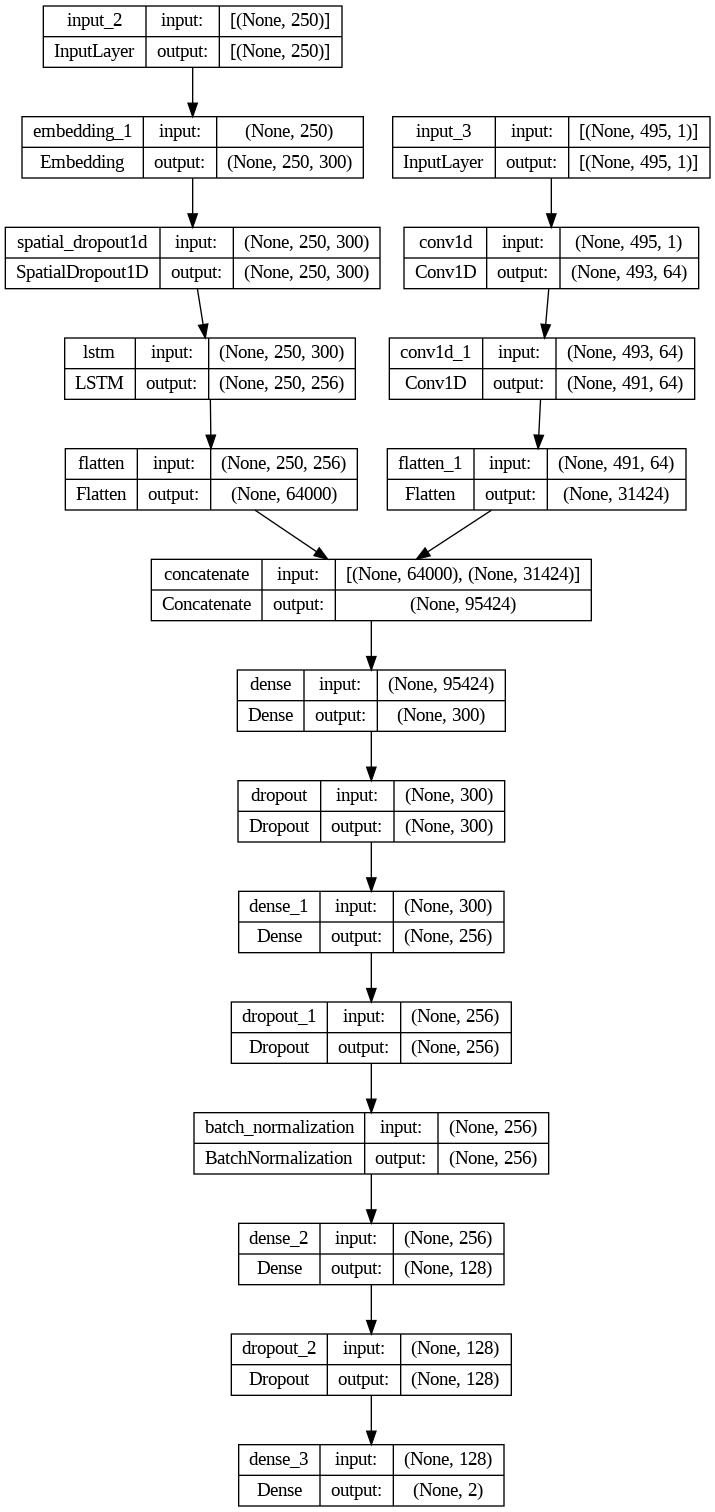

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# input 1
input1 = Input(batch_shape=(None,250))
x1 = Embedding(input_dim=44987,output_dim= 300,weights=[embedding_mat(feature_names[0])],trainable = False)(input1)
x1 = SpatialDropout1D(0.3)(x1)
x1 = CuDNNLSTM(256,return_sequences=True)(x1)
x1 = Flatten()(x1)

# input 2
input2 = Input(shape=(495,1))
x2 = Conv1D(filters=64,kernel_size=3,strides=1)(input2)
x2 = Conv1D(filters=64,kernel_size=3,strides=1)(x2)
x2 = Flatten()(x2)

# merging both the inputs
concat = concatenate([x1,x2])
x = Dense(300,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.4)(x)
x = Dense(256,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.6)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with two inputs
model = Model([input1,input2], output)
model.load_weights("weights_3.best_copy.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0006,decay = 1e-4), metrics=[auc])

In [ ]:
print("Auc for test data: %0.3f"%roc_auc_score(y_test,model.predict([X_test,test])))
print("Auc for CV data: %0.3f"%roc_auc_score(y_cv,model.predict([X_cv,cv])))
print("Auc for train data: %0.3f"%roc_auc_score(y_train,model.predict([X_train,train])))

1025/1025 [==============================] - 8s 7ms/step
Auc for test data: 0.747
478/478 [==============================] - 4s 9ms/step
Auc for CV data: 0.759
1912/1912 [==============================] - 15s 8ms/step
Auc for train data: 0.776
